<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/projetNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv


In [11]:
!pip install wikidata --quiet

import pandas as pd
from wikidata.client import Client
import requests

In [34]:
df_train = pd.read_csv('/content/[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep = '\t')

#subclasses (P279)

We are looking for the shortest path from the given item to a 'root' item that has not any subclass. We then define the depth of each item in the graph of subclasses as the number of nodes in the shortest path.

In [41]:
import requests
from collections import deque
from functools import lru_cache
from tqdm import tqdm

WIKIDATA_SPARQL_URL = "https://query.wikidata.org/sparql"
HEADERS = {
    "Accept": "application/sparql-results+json",
    "User-Agent": "ExplorateurWikidata/0.1 (truc@truc.com)"
}

def extract_entity_id(url):
    return url.strip().split("/")[-1]

@lru_cache(maxsize=None)
def get_superclasses(qid):
    """Superclasses (P279) with cache."""
    query = f"""
    SELECT ?superclass WHERE {{
      wd:{qid} wdt:P279 ?superclass.
    }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    return tuple(r["superclass"]["value"].split("/")[-1] for r in results)

def get_subclass_depth_bfs(url, max_depth=20):
    """get the depth by finding the shortest path with BFS"""
    qid = extract_entity_id(url)
    visited = set()
    queue = deque([(qid, 1)])

    while queue:
        current_qid, depth = queue.popleft()
        if current_qid in visited:
            continue
        visited.add(current_qid)

        parents = get_superclasses(current_qid)
        if not parents:
            return depth
        if depth >= max_depth:
            return None
        for parent_qid in parents:
            queue.append((parent_qid, depth + 1))

    return None


In [36]:
tqdm.pandas()
df_train["subclass_depth"]= df_train["item"].progress_apply(get_subclass_depth_bfs)

100%|██████████| 6251/6251 [25:17<00:00,  4.12it/s]


## Subclasses downward

In [13]:
def get_direct_subclasses(url):
    """return the number of subclasses """
    qid = extract_entity_id(url)
    query = f"""
    SELECT ?subclass WHERE {{
      ?subclass wdt:P279 wd:{qid} .
    }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    #return [r["subclass"]["value"].split("/")[-1] for r in results]
    return len(results)


In [14]:
df_train["subclasses"] = df_train["item"].apply(get_direct_subclasses)

# Instances of (P31) downward

Here I explore the concept of the instances of the entity. Mainly I check how many entities on the wikipedia are the instances of the given entity, later i group the outcomes by the labels and plot them to see whether there is any meaningfull correlation

In [17]:
def get_instances_of(url):
  qid = extract_entity_id(url)
  """return  number of items that are 'instances of' the given entity"""
  query = f"""
  SELECT ?entity ?label WHERE {{
    ?entity wdt:P31 wd:{qid}.
    ?entity rdfs:label ?label .
    FILTER(LANG(?label) = "en")
  }}
  """
  response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
  results = response.json()["results"]["bindings"]
  #return [(r["class"]["value"].split("/")[-1], r["label"]["value"]) for r in results ]
  return len(results)


In [18]:
df_train["instances_of"] = df_train["item"].apply(get_instances_of)

In [ ]:
df_train[df_train["instances_of"] != 0]

,item,name,description,type,category,subcategory,label,instances_of
61,http://www.wikidata.org/entity/Q19772737,political candidate,candidate in an election for political office,concept,politics,politician,cultural agnostic,7
75,http://www.wikidata.org/entity/Q4175034,legislator,member of a legislature,concept,politics,politician,cultural agnostic,2
78,http://www.wikidata.org/entity/Q5261098,deputy party leader,second-in-command of a political party,concept,politics,politician,cultural agnostic,3
85,http://www.wikidata.org/entity/Q2285706,head of government,chief officer of the executive branch of a gov...,concept,politics,politician,cultural agnostic,40
86,http://www.wikidata.org/entity/Q1688932,jiedushi,regional military governor function,concept,politics,politician,cultural exclusive,3
...,...,...,...,...,...,...,...,...
6201,http://www.wikidata.org/entity/Q287414,neighborhood in New York City,neighborhood located within one of the five bo...,concept,geography,neighborhood,cultural exclusive,4
6203,http://www.wikidata.org/entity/Q201759,slum,heavily populated urban settlement characteriz...,concept,geography,neighborhood,cultural agnostic,19
6204,http://www.wikidata.org/entity/Q188509,suburb,human settlement that is part of or near to a ...,concept,geography,neighborhood,cultural agnostic,8223
6205,http://www.wikidata.org/entity/Q75848,gated community,residental community with controlled entrances...,concept,geography,neighborhood,cultural agnostic,44


['cultural representative', 'cultural exclusive', 'cultural agnostic']


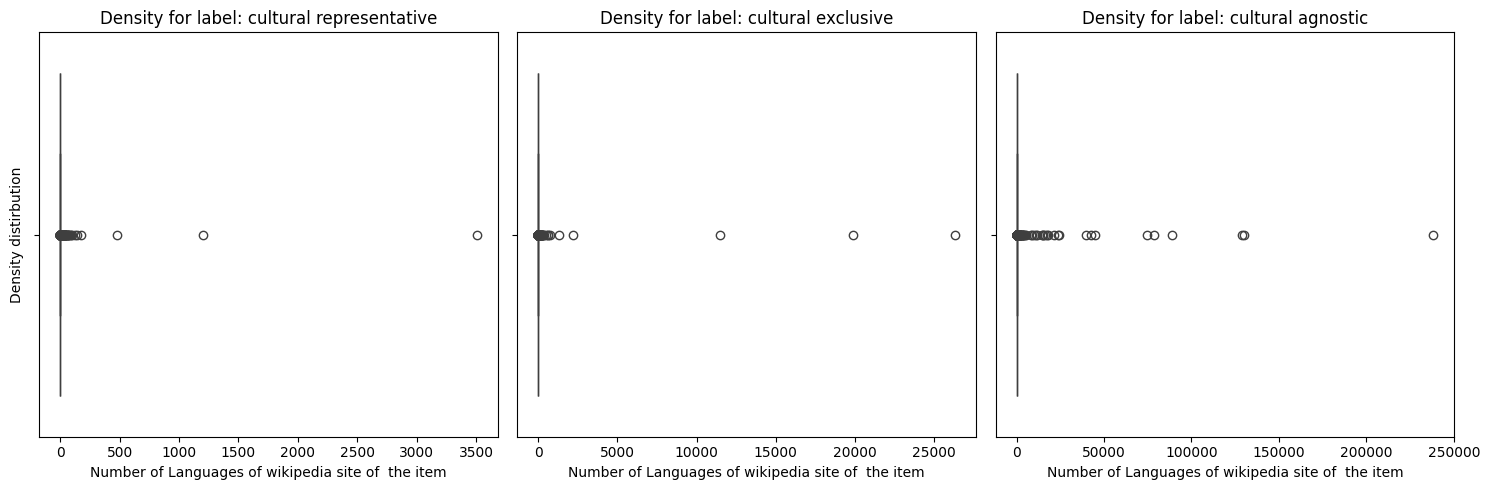

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_train['instances_of'] = pd.to_numeric(df_train['instances_of'], errors='coerce')
#categories = list(set(df_lang['label']))

'''the box plots are utterly uninformative due to discrepancy of data magnitude'''
# categories = ['cultural representative','cultural exclusive','cultural agnostic']
# print(categories)
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


# for i, label in enumerate(categories):
#     ax = axes[i]
#     subset = df_train[df_train['label'] == label]
#     sns.boxplot(data=subset, x='instances_of', fill=True, ax=ax)
#     ax.set_title(f'Density for label: {label}')
#     ax.set_xlabel('Number of Languages of wikipedia site of  the item')
#     ax.set_ylabel('Density distirbution')
#     plt.tight_layout()
# plt.show()

### Here printed the means for each group and the lengths to see whether there could be a data imbalance issue

In [ ]:
print('mean number of instances of entity for cultural representative is:')
print(df_train[df_train['label'] == 'cultural representative']['instances_of'].sum()/len(df_train[df_train['label'] == 'cultural representative']))
print('mean number of instances of entity for cultural exclusive is:')
print(df_train[df_train['label'] == 'cultural exclusive']['instances_of'].sum()/len(df_train[df_train['label'] == 'cultural exclusive']))
print('mean number of instances of entity for cultural agnostic is:')
print(df_train[df_train['label'] == 'cultural agnostic']['instances_of'].sum()/len(df_train[df_train['label'] == 'cultural agnostic']))


print('number of cultural representative entities is:')
print(len(df_train[df_train['label'] == 'cultural representative']))
print('number of cultural exclusive entities is:')
print(len(df_train[df_train['label'] == 'cultural exclusive']))
print('number of cultural agnostic entities is:')
print(len(df_train[df_train['label'] == 'cultural agnostic']))

mean number of instances of entity for cultural representative is:
4.452818991097923
mean number of instances of entity for cultural exclusive is:
25.659590316573556
mean number of instances of entity for cultural agnostic is:
638.3324382384533
number of cultural representative entities is:
1685
number of cultural exclusive entities is:
2685
number of cultural agnostic entities is:
1862


### Plotting the relations to see the magnitude

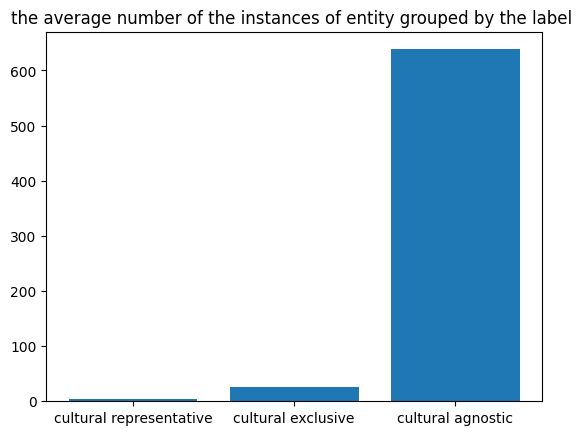

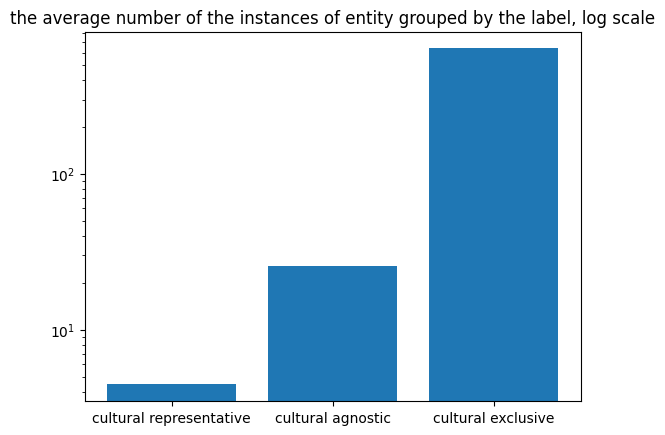

In [ ]:
mean_representative =df_train[df_train['label'] == 'cultural representative']['instances_of'].sum()/len(df_train[df_train['label'] == 'cultural representative'])
mean_exclusive = df_train[df_train['label'] == 'cultural exclusive']['instances_of'].sum()/len(df_train[df_train['label'] == 'cultural exclusive'])
mean_agnostic = df_train[df_train['label'] == 'cultural agnostic']['instances_of'].sum()/len(df_train[df_train['label'] == 'cultural agnostic'])

categories = ['cultural representative','cultural exclusive','cultural agnostic',]
numbers =   [mean_representative, mean_exclusive, mean_agnostic]
plt.title('the average number of the instances of entity grouped by the label ')
# plot a bar chart
plt.bar(categories, numbers)
plt.show()



categories = ['cultural representative','cultural agnostic','cultural exclusive']
numbers =   [mean_representative, mean_exclusive, mean_agnostic]
plt.title('the average number of the instances of entity grouped by the label, log scale')
# plot a bar chart with logarithmic scale
plt.yscale('log')
plt.bar(categories, numbers)
plt.show()

# Instances of (P31) upward
Again instances of but now in reversed way how many other entites the given item is an instance of

In [21]:
def get_instances_of_up(url):
  qid = extract_entity_id(url)
  """return  number of  'instances of' the given entity"""
  query = f"""
  SELECT ?entity ?label WHERE {{
    ?entity wd:{qid} wdt:P31 .
    ?entity rdfs:label ?label .
    FILTER(LANG(?label) = "en")
  }}
  """
  response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
  results = response.json()["results"]["bindings"]
  #return [(r["class"]["value"].split("/")[-1], r["label"]["value"]) for r in results ]
  return len(results)

In [22]:
df_train["instances_of_up"] = df_train["item"].apply(get_instances_of_up)

In [ ]:
df_train.to_csv('train_set_instances.csv')

#plot to see the distribution of number of instances among the agnostic and the non agnostic

In [ ]:
df = df_train.loc[lambda x: x.label == "cultural agnostic"]
df1 = df_train.loc[lambda x: x.label != "cultural agnostic"]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Distribution des valeurs
counts = df["instances_of"].value_counts().sort_index()

counts1 = df1["instances_of"].value_counts().sort_index()

# Proportions (en % ou ratio)
proportions = counts / counts.sum()

proportions1 = counts1 / counts1.sum()


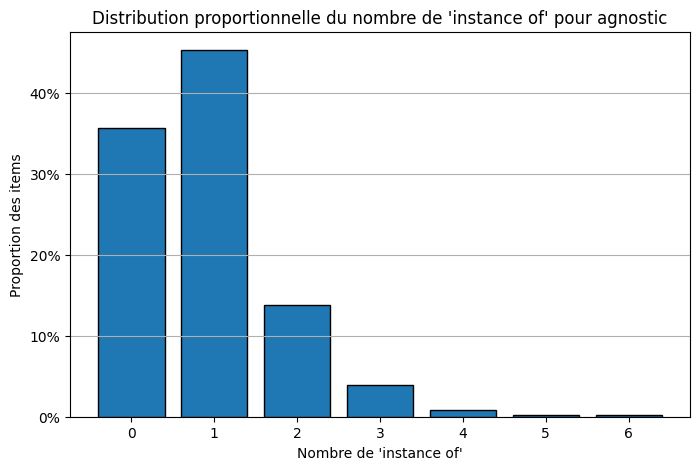

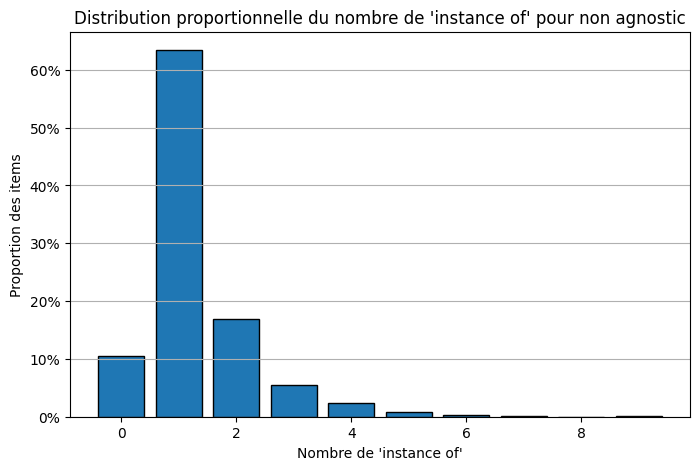

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(proportions.index, proportions.values, width=0.8, edgecolor='black')

plt.title("Distribution proportionnelle du nombre de 'instance of' pour agnostic")
plt.xlabel("Nombre de 'instance of'")
plt.ylabel("Proportion des items")
plt.grid(axis='y')

# Optionnel : afficher en pourcentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.figure(figsize=(8, 5))
plt.bar(proportions1.index, proportions1.values, width=0.8, edgecolor='black')

plt.title("Distribution proportionnelle du nombre de 'instance of' pour non agnostic")
plt.xlabel("Nombre de 'instance of'")
plt.ylabel("Proportion des items")
plt.grid(axis='y')

# Optionnel : afficher en pourcentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.show()


# saving the dataset with 3 new features

In [29]:
df_train.to_json('trainset_subclass_instances.json', orient='records', lines=True)